In [1]:
import json, os, sys
%load_ext autoreload
%autoreload 2
os.environ["CUDA_VISIBLE_DEVICES"]="1"
# from utils import session_config
# session_config.setup_gpus(True, 0.95)

from matplotlib import pyplot as plt
import tensorflow as tf
import cv2
import numpy as np
from utils.iou import compute_iou

# load image information from coco object

In [2]:
sys.path.append("/home/files/cocoapi/PythonAPI")
from pycocotools.coco import COCO
coco = COCO("annotations/integrated_annotation.json")

train_ids = np.load("annotations/train_ids.npy")
print("train-data length : {}".format(len(train_ids)))
val_ids = np.load("annotations/val_ids.npy")
print("train-data length : {}".format(len(val_ids)))

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!
train-data length : 9000
train-data length : 1737


# Show a image

In [3]:
image = coco.loadImgs(33877)
image_array = cv2.imread("detection" + image[0]["path"])[:,:,::-1]
anno_ids = coco.getAnnIds(imgIds=33877, catIds=[0], iscrowd=None)
anns = coco.loadAnns(anno_ids)

image_array = image_array[np.newaxis,...]
patches = tf.image.extract_patches(images=image_array,
                           sizes=[1, 1000, 1024, 1],
                           strides=[1, 500, 1, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')
patches = tf.squeeze(patches)
patches = tf.reshape(patches, (19, 1000,1024,3))

bbox = []
for ann in anns:
    x,y,w,h = ann["bbox"]
    x,y,w,h = x/2024,y/10000,w/2024,h/10000
    bbox.append([x,y,x+w,y+h])   
bbox = np.array(bbox)
    
boxes = np.zeros([19,4])
for i in range(19):
    boxes[i] = [0,0+0.05*i,1,0.1+0.05*i]
    
ious = compute_iou(bbox, boxes)
ious = np.sum(ious, axis=0)
ious = tf.squeeze(ious)
labels = tf.where(ious>0, 1, 0)

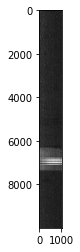

(1, 10000, 1024, 3)
(19, 1000, 1024, 3)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0], shape=(19,), dtype=int32)


In [4]:
plt.imshow(image_array[0])
plt.show()
print(image_array.shape)
print(patches.shape)
print(labels)

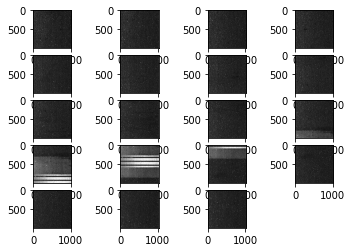

In [5]:
fig = plt.figure()
for i in range(20):
    if i != 19:
        ax = fig.add_subplot(5,4,i+1)
        ax.imshow(patches[i])